# **Training with PyTorch**

# Dataset and DataLoader

Dataset : 저장소에서 단일 샘플을 읽고 전처리한다

DataLoader : Dataset에서 샘플을 뽑아 배치 단위로 모아 학습 루프에 전달

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

training_set = torchvision.datasets.FashionMNIST(
    'data',
    train = True,
    transform = transform,
    download = True
)

validation_set = torchvision.datasets.FashionMNIST(
    'data',
    train = False,
    transform = transform,
    download = True
)

training_loader = torch.utils.data.DataLoader(training_set, batch_size = 4, shuffle = True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size = 4, shuffle = False)

classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

print('Training set has {} instances'.format(len(training_set)))
print('Validation set has {} insatnces'.format(len(validation_set)))

100%|██████████| 26.4M/26.4M [00:02<00:00, 9.74MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 172kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.06MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 10.5MB/s]

Training set has 60000 instances
Validation set has 10000 insatnces


Shirt  T-shirt/top  Coat  Pullover


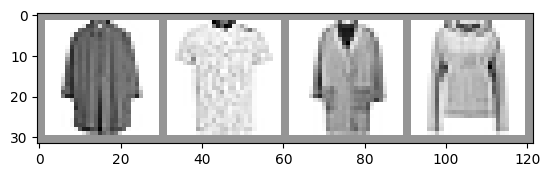

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def matplotlib_imshow(img, one_channel = False):
  if one_channel:
    img = img.mean(dim =0 )
  img = img / 2 + 0.5
  npimg = img.numpy()
  if one_channel:
    plt.imshow(npimg, cmap='Greys')
  else:
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(training_loader)
images, labels = next(dataiter)

img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel = True)
print('  '.join(classes[labels[j]] for j in range(4)))

# The Model

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class GarmentClassifier(nn.Module):
  def __init__(self):
    super(GarmentClassifier, self).__init__()
    self.conv1 = nn.Conv2d(1, 6, 5)
    self.pool = nn.MaxPool2d(2,2)
    self.conv2 = nn.Conv2d(6, 16, 5)

    self.fc1 = nn.Linear(16 * 4 * 4, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 16 * 4 * 4)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    return x

model = GarmentClassifier()

# Loss Function

In [ ]:
loss_fn = torch.nn.CrossEntropyLoss()

dummy_outputs = torch.rand(4, 10)
dummy_labels = torch.tensor([1, 5, 3, 7])

print(dummy_outputs)
print(dummy_labels)

loss = loss_fn(dummy_outputs, dummy_labels)
print('Total loss for this batch: {}'.format(loss.item()))

tensor([[0.0699, 0.9158, 0.2132, 0.8251, 0.7912, 0.4241, 0.6267, 0.5981, 0.7487,
         0.4525],
        [0.7707, 0.0407, 0.8742, 0.0203, 0.9161, 0.9635, 0.4590, 0.1107, 0.9366,
         0.0679],
        [0.0118, 0.0728, 0.1572, 0.7414, 0.7874, 0.2361, 0.7182, 0.8869, 0.9522,
         0.6595],
        [0.4167, 0.7396, 0.3057, 0.3742, 0.6142, 0.0573, 0.1491, 0.1052, 0.4034,
         0.9165]])
tensor([1, 5, 3, 7])
Total loss for this batch: 2.1743152141571045


# Optimizer

In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr = 0.001, momentum = 0.9)

# The Training Loop

In [ ]:
def train_one_epoch(epoch_index, tb_writer):
  running_loss = 0. # 배치 누적손실
  last_loss = 0. # 직전 1000배치 평균 손실

  for i, data in enumerate(training_loader):
    inputs, labels = data
    optimizer.zero_grad() # 기울기 초기화
    outputs = model(inputs) # 이번 배치 예측
    loss = loss_fn(outputs, labels) # 로스 계산
    loss.backward() # 역전파
    optimizer.step() # 가중치 업데이트

    # 진행 상황 기록
    running_loss += loss.item()
    if i % 1000 == 999:
      last_loss = running_loss / 1000
      print('batch {} loss: {{}}'.format(i + 1, last_loss))

      tb_x = epoch_index * len(training_loader) + i + 1
      tb_writer.add_scalar('Loss/train', last_loss, tb_x)

      running_loss = 0. # 누적 손실 초기화

  return last_loss # 에폭 마지막 1000 배치 평균 손실 반환

# Per-Epoch Activity

In [ ]:
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
epoch_number = 0

EPOCHS = 5
best_vloss = 1_000_000.

for epoch in range(EPOCHS):
  print(' EPOCH {}:'.format(epoch_number + 1))

  model.train(True)
  avg_loss = train_one_epoch(epoch_number, writer)

  running_vloss = 0.0
  model.eval()

  with torch.no_grad():
    for i, vdata in enumerate(validation_loader):
      vinputs, vlabels = vdata
      voutputs = model(vinputs)
      vloss = loss_fn(voutputs, vlabels)
      running_vloss += vloss

  avg_vloss = running_vloss / (i + 1)
  print('Loss train {} valid {}'.format(avg_loss, avg_vloss))

  writer.add_scalars('Tranining vs. Validation Loss', { 'training' : avg_loss, 'Validation': avg_vloss},
                     epoch_number + 1)

  writer.flush()

  # 제일 좋은 validation 이였으면 모델 저장
  if avg_vloss < best_vloss:
    best_vloss = avg_vloss
    model_path = 'model_{}_{}'.format(timestamp, epoch_number)
    torch.save(model.state_dict(), model_path)

  epoch_number += 1

 EPOCH 1:
batch 1000 loss: {}
batch 2000 loss: {}
batch 3000 loss: {}
batch 4000 loss: {}
batch 5000 loss: {}
batch 6000 loss: {}
batch 7000 loss: {}
batch 8000 loss: {}
batch 9000 loss: {}
batch 10000 loss: {}
batch 11000 loss: {}
batch 12000 loss: {}
batch 13000 loss: {}
batch 14000 loss: {}
batch 15000 loss: {}
Loss train 0.26679123430237994 valid 0.31594839692115784
 EPOCH 2:
batch 1000 loss: {}
batch 2000 loss: {}
batch 3000 loss: {}
batch 4000 loss: {}
batch 5000 loss: {}
batch 6000 loss: {}
batch 7000 loss: {}
batch 8000 loss: {}
batch 9000 loss: {}
batch 10000 loss: {}
batch 11000 loss: {}
batch 12000 loss: {}
batch 13000 loss: {}
batch 14000 loss: {}
batch 15000 loss: {}
Loss train 0.2524857627506399 valid 0.31604132056236267
 EPOCH 3:
batch 1000 loss: {}
batch 2000 loss: {}
batch 3000 loss: {}
batch 4000 loss: {}
batch 5000 loss: {}
batch 6000 loss: {}
batch 7000 loss: {}
batch 8000 loss: {}
batch 9000 loss: {}
batch 10000 loss: {}
batch 11000 loss: {}
batch 12000 loss: {}
ba

In [ ]:
saved_model = GarmentClassifier()
saved_model.load_state_dict(torch.load(PATH))